# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №1. Image Classification. </center>

В данной лабораторной работе вам предлагается обучить модель на основе нейронной сети для распознавания рукописных букв английского алфавита.

## Данные

Данные представлены двумя датасетами: обучающим (`train`) и тестовым (`test`). Изображения для каждого датасета находятся в `images.zip`.  
  
Обучающая выборка состоит из 65000 изображений - по 2500 изображений для каждой буквы.  
Тестовая выборка состоит из 13000 изображений - по 500 изображений для каждой буквы.  
  
Все изображения - монохромные (но в формате RGB), размерности $28 \times 28$ пикселей, в формате JPEG. 
В названии каждого файла содержатся буква, которая представлена на изображении, и уникальный номер изображения: `a_00002.jpg`.  
  
**NB:** Все изображения представлены в перевернутом виде, для корректного отображения их нужно сначала транспонировать. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
pic = plt.imread('images/train/a/a_00002.jpg')
print(pic.shape)

(28, 28, 3)


In [3]:
pic = np.transpose(pic, axes=(1, 0, 2))

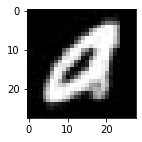

In [4]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

Ваша задача - создать и обучить модель на основе нейронной сети, которая будет предсказывать букву на картинке.  
Обучение необходимо проводить на данных из `train`, качество модели проверять на данных из `test`.  
Целевая метрика - accuracy.  
Для моделирования необходимо использовать `pytorch`.

## Основные задания

In [5]:
import os
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader

In [6]:
def get_data_and_targets_lst(path):
    data=[]
    targets=[]
    for root, currentDirectory, files in os.walk(path):
        for file in files:
            pic = plt.imread(os.path.join(root, file))
            pic = torch.tensor(np.transpose(pic, axes=(1, 0, 2)))
            pic = torch.div(pic, 255)
            target = ord(file[0]) - ord('a')
            data.append(pic)
            targets.append(target)
    return data,targets

In [7]:
class MyDataset(torch.utils.data.Dataset): 
    
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        #return {'sample': self.x[idx], 'target': self.y[idx]}
        return self.x[idx],self.y[idx]

In [8]:
X,y = get_data_and_targets_lst("images/train")

In [9]:
X[60000].dtype

torch.float32

15


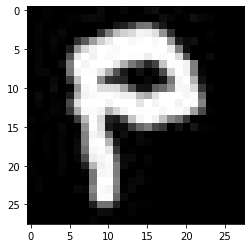

In [10]:
plt.imshow(X[60000])
print(y[60000])

In [11]:
len(y)

65000

In [12]:
# for i in range(len(y)):
#     ls = [0 for a in range(26)]
#     ls[y[i]] = 1
#     y[i]= ls

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [14]:
len(X_test), len(y_test)

(13000, 13000)

In [15]:
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
#train_dataset.__getitem__(40000)

In [16]:
batch_size=64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
for batch, (X, y) in enumerate(train_dataloader):
    print(batch)
    print(y)
    print("Shape of X [N, C, H, W]: ", X.shape)
    #NHWC now
    print("Shape of y: ", y.shape, y.dtype)
    break

0
tensor([ 4,  7, 16, 15,  0, 13, 20, 25, 13, 15, 17,  1,  0,  5,  6, 19, 24, 14,
        15,  6, 11, 20,  0,  4, 13, 22,  0, 15, 18,  7,  7,  0, 24, 14,  0, 18,
        13, 23,  7, 18, 19, 19, 12, 17, 16,  0,  9,  7,  4, 18,  9,  7, 18, 22,
        14,  4, 24, 19,  8, 17,  6, 18, 19,  6])
Shape of X [N, C, H, W]:  torch.Size([64, 28, 28, 3])
Shape of y:  torch.Size([64]) torch.int64


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [18]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [69]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            #print(pred.shape)
            #print(loss_fn(pred, y).item())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [70]:
def learning_cycle(epochs, model, loss_fn, optimizer):
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test(test_dataloader, model, loss_fn)
        #print("Done!")
    

# 1.1

In [82]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 26),
            #nn.Softmax(dim=-1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [83]:
model_lin3 = NeuralNetwork()

In [84]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_lin3.parameters(), lr=0.001)

In [85]:
learning_cycle(50, model_lin3, loss_fn, optimizer)

Epoch 1
-------------------------------
loss: 3.258257  [    0/52000]
loss: 3.258403  [ 6400/52000]
loss: 3.257913  [12800/52000]
loss: 3.258225  [19200/52000]
loss: 3.258302  [25600/52000]
loss: 3.257796  [32000/52000]
loss: 3.258325  [38400/52000]
loss: 3.258126  [44800/52000]
loss: 3.257941  [51200/52000]
Test Error: 
 Accuracy: 4.7%, Avg loss: 3.258083 

Epoch 2
-------------------------------
loss: 3.258201  [    0/52000]
loss: 3.258363  [ 6400/52000]
loss: 3.257861  [12800/52000]
loss: 3.258172  [19200/52000]
loss: 3.258260  [25600/52000]
loss: 3.257751  [32000/52000]
loss: 3.258265  [38400/52000]
loss: 3.258080  [44800/52000]
loss: 3.257884  [51200/52000]
Test Error: 
 Accuracy: 4.9%, Avg loss: 3.258032 

Epoch 3
-------------------------------
loss: 3.258146  [    0/52000]
loss: 3.258323  [ 6400/52000]
loss: 3.257809  [12800/52000]
loss: 3.258119  [19200/52000]
loss: 3.258217  [25600/52000]
loss: 3.257705  [32000/52000]
loss: 3.258205  [38400/52000]
loss: 3.258033  [44800/52000

KeyboardInterrupt: 

In [ ]:
X_train[0].shape

In [76]:
pred = model_lin3(X_train[0].reshape([1,28,28,3]))

In [77]:
pred

tensor([[0.0387, 0.0402, 0.0384, 0.0392, 0.0462, 0.0359, 0.0386, 0.0393, 0.0349,
         0.0335, 0.0386, 0.0407, 0.0366, 0.0372, 0.0413, 0.0396, 0.0381, 0.0401,
         0.0369, 0.0388, 0.0400, 0.0379, 0.0381, 0.0364, 0.0374, 0.0375]],
       grad_fn=<SoftmaxBackward0>)

### Задание 1  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели с 2-мя и 3-мя полносвязными (dense) скрытыми слоями.  
При моделировании необходимо попробовать разные параметры нейронной сети - число нейронов на каждом слое, learning rate, batch size, функции активации, регуляризации и т.д. Оцените качество моделей с различными параметрами, проведите сравнительный анализ. 
2. Для наилучшей модели постройте confusion matrix результатов предсказаний модели на тестовых данных.  
Насколько равномерно обучилась ваша модель? Приведите буквы с самой лучшей и с самой худшей точностью детекции.
3. Найдите 10 пар букв, которые чаще всего путаются между собой, дайте возможное объяснение. Приведите примеры с картинками, которые были детектированы с ошибкой.
4. Возьмите первую букву вашей фамилии и укажите её точность детекции. С какими буквами ваша модель чаще всего путает эту букву?     

### Задание 2  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  
Попробуйте различные значения параметров сверток и числа фильтров на каждом слое. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.  
2. Для наилучшей конфигурации из предыдущего пункта, сравните, как меняется качество модели при увеличении размера батча при использовании BatchNorm и GroupNorm.    

### Задание 3    
  
Обучите модель с точностью (accuracy) на тестовых данных:  
- `>= 0.85`    +1 балл
- `>= 0.95`    +2 балла
- `>= 0.99`    +3 балла  

## Бонусные задания

**Задание 1 (1 балл).**  

Напишите на листке белой бумаги (маркером или ручкой) от 5 разных букв (можно больше 5 букв в целом с повторениями, но должно быть минимум 5 разных) английского алфавита (в датасете есть как прописные, так и строчные буквы). Сфотографируйте букву и приведите её картинку к размеру $28\times28$ и, желательно, к чёрно-белой палитре цветов. Передайте получившиеся изображения вашей модели и выполните предсказание, оцените результат.  
  
**Tips:**  
- В датасете все буквы занимают практически всё пространство картинки по высоте или ширине (или вместе). Если ваша буква будет слишком маленькой или большой, это может повлиять на результат детекции.
- Помните, что буква должна быть белого цвета, а фон - чёрного.
- Описание ваших действий при выполнении этого задания (что вы использовали, чтобы привести картинку к нужному виду) категорически приветствуется :)

**Задание 2 (1 балл):**    
  
Используйте transfer learning подход для решения задачи - дообучите какую-либо модель, предобученную на ImageNet, для классификации рукописных букв. Оцените качество решения.  
В качестве предобученой модели можно взять одну из [torchvision models](https://pytorch.org/vision/stable/models.html).

**Задание 3 (1 балл):**  
  
Добавьте вывод значений функции потерь и accuracy в tensorboard.  
Метрики нужно выводить и для обучающей, и для тестовой выборки.